In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [25]:
bbb_df = pd.read_csv('adenot_processed.csv')
bbb_df

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,THEOBROMINE,Cn1cnc2c1C(=O)NC(=O)N2C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1666,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1667,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [3]:
bbb_df[bbb_df['Drug'] == 'COBALAMINE']

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023


## Getting Fingerprints

In [4]:
r = 2
d = 1024

fp_list = []
for smile in bbb_df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        print('invalid SMILES')
        bbb_df = bbb_df[bbb_df['SMILES'] != smile]
    else: 
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,r,nBits=d,useChirality=False)
        fp_list.append(fp)

morgan_list = np.array(fp_list)
print(morgan_list.shape)
print(bbb_df.shape)

(1669, 1024)
(1669, 1027)


## K-Means Clustering

In [5]:
k = 4
kmeans = KMeans(n_clusters=k).fit(morgan_list)
cluster_index = kmeans.predict(morgan_list)

In [26]:
bbb_df.insert(3, 'Cluster_Index', cluster_index)
bbb_df

,Drug,SMILES,permeable,Cluster_Index,0,1,2,3,4,5,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0.0,3,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0.0,1,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,THEOBROMINE,Cn1cnc2c1C(=O)NC(=O)N2C,1.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1665,AMITRIPTYLINE,CN(C)CCC=C1c2ccccc2CCc2ccccc12,1.0,3,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1666,CHLORPROMAZINE,CN(C)CCCN1c2ccccc2Sc2ccc(cc12)Cl,1.0,2,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1667,DISULFIRAM,CCN(CC)C(=S)SSC(=S)N(CC)CC,1.0,3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [30]:
count = np.bincount(cluster_index)
index = np.arange(len(count))
number = [i for i in count]
percent = [round(100*i/len(cluster_index), 2) for i in number]
perc_perm = []

for i in index:
    bbb_i = bbb_df[bbb_df['Cluster_Index'] == i]
    num_perm = len(bbb_i[bbb_i['permeable'] == 1])
    perc_perm.append(num_perm/len(bbb_i))

cluster_df = pd.DataFrame(
    {'cluster_index': index,
    'number': number,
    'percentage': percent,
    'percent permeable': perc_perm
    }, index = None)

cluster_df

,cluster_index,number,percentage,percent permeable
0,0,159,9.53,0.974843
1,1,224,13.42,0.000000
2,2,412,24.69,0.963592
3,3,874,52.37,0.876430


## Principal Component Analysis

In [7]:
dim = 100
pca = PCA(n_components=dim)
components = pca.fit_transform(morgan_list)

In [8]:
print("Overall Variance Captured by PCA-1 and PCA-2: ", sum(pca.explained_variance_ratio_[0:2]))
print("50 Principal Components Total Explained Variance: ", sum(pca.explained_variance_ratio_))
print("Fraction of Overall Variance Captured: ",  sum(pca.explained_variance_ratio_[0:2])/sum(pca.explained_variance_ratio_))

Overall Variance Captured by PCA-1 and PCA-2:  0.09688364723089951
50 Principal Components Total Explained Variance:  0.6526579483410282
Fraction of Overall Variance Captured:  0.14844475192122483


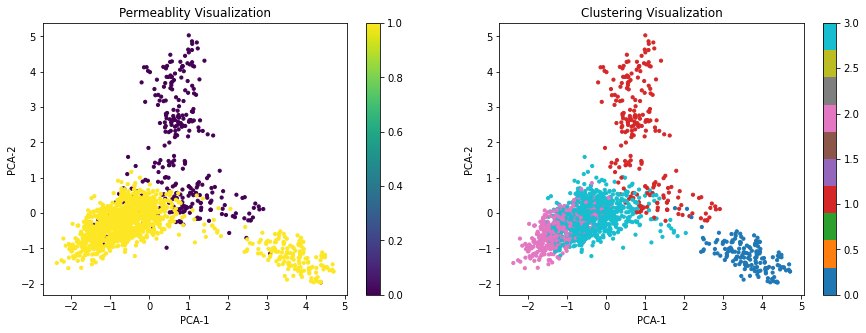

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(components[:,0], components[:,1], c=bbb_df['permeable'],s=10)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Permeablity Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(components[:,0], components[:,1], c=cluster_index,s=10, cmap='tab10')
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('Clustering Visualization')
plt.colorbar()

## t-SNE

In [10]:
tsne = TSNE(n_components=2, random_state=0)
t_components = tsne.fit_transform(components)

C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Jamie Wang\anaconda3\envs\bme590\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


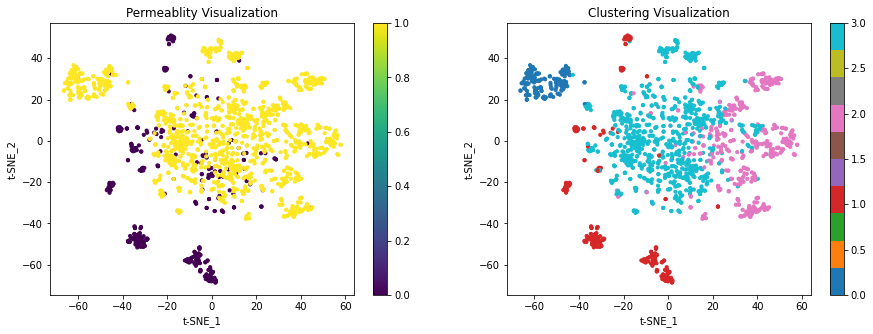

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(t_components[:,0], t_components[:,1], c=bbb_df['permeable'],s=10)
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Permeablity Visualization')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(t_components[:,0], t_components[:,1], c=cluster_index,s=10, cmap='tab10')
plt.xlabel('t-SNE_1')
plt.ylabel('t-SNE_2')
plt.title('Clustering Visualization')
plt.colorbar()

## Get Fragments By Cluster
### + Scaffold Analysis

In [50]:
from rdkit.Chem import (
    AllChem,
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys
)

In [40]:
## copied from xgboost model

important_features = [  64,  268,  881,  650,  926,  695,  726,  314,  656,  250,  893,
        147,  679,  294,  222,  875,   80,  283, 1019,  301,  389,  935,
         84,   36,  175,  121,    1,  557,  378,   15,   33,  967,  412,
       1017,  456,  932,  946,  128,  356,  739,  841,  512,  887,  130,
        285,  428,  714,  561,  226,  698,   90,  659,  973,  694,  114,
        231,  849,  547,  341,  816,  392,  333,  102,  904,  140,  807,
        486,  745,  367,  138,  578,  227,  673,  842,  233,  352,  767,
        753,  583,  897,  237,  407, 1005,  519,  116,  143,  197,  212,
        447,  255,  981,    0,  687,  464,  202,  872,  272,  399,  215,
        919,  829,  675,  722,  808,  299,  658,  606,  410,  723,  430,
        253,    5,  357,  463,  387]
print(len(important_features))

115


In [32]:
def get_fragments(smiles_set, feature_list):
    fragments_df = pd.DataFrame(columns=['Fragment', 'Count'])
    r=2
    d=1024
    for smile in smiles_set:
        m = Chem.MolFromSmiles(smile)
        info={}
        fp = AllChem.GetMorganFingerprintAsBitVect(m,r,d,bitInfo=info)
        fragments = []
        for bit in info.keys():
            if bit in feature_list:
                root_atom = info[bit][0][0]
                radius = info[bit][0][1]
                env = Chem.FindAtomEnvironmentOfRadiusN(m,radius,root_atom)
                amap={}
                submol=Chem.PathToSubmol(m,env,atomMap=amap)
                if amap:
                    fragment = Chem.MolToSmiles(submol, rootedAtAtom=amap[root_atom],canonical=False)
                else:
                    fragment = Chem.MolToSmiles(submol)
                fragments.append(fragment)
        
        for fragment in fragments:
            if fragment in fragments_df['Fragment'].values:
                index = fragments_df.index[fragments_df['Fragment'] == fragment]
                fragments_df.at[index[0],'Count'] = fragments_df.at[index[0],'Count'] + 1
            else:
                row = {'Fragment': [fragment], 'Count': [1]}
                row_df = pd.DataFrame(data=row)
                fragments_df = pd.concat([fragments_df, row_df], ignore_index=True)
    return fragments_df

### Cluster 0

In [61]:
#Cluster 0 fragment counts for most important features
fragments_c0 = get_fragments(bbb_df[bbb_df['Cluster_Index'] == 0]['SMILES'], important_features[-50:])
fragments_c0 = fragments_c0.sort_values(by=['Count'], ascending=False)[1:]
fragments_c0.head(20)

,Fragment,Count
2,OC,142
8,C(C)(C)(C)C,84
7,[C@H](C)(C)C,77
1,C(C)C,68
3,C(C)(C)C,66
21,[C@@H](CC)(F)C(=C)C,40
9,[C@@H](C)(C)C,16
19,[C@H]([C@H](C)C)(C(C)(C)C)[C@@H](O)C,8
6,C(C(C)=O)O,6
16,O(C)C,6


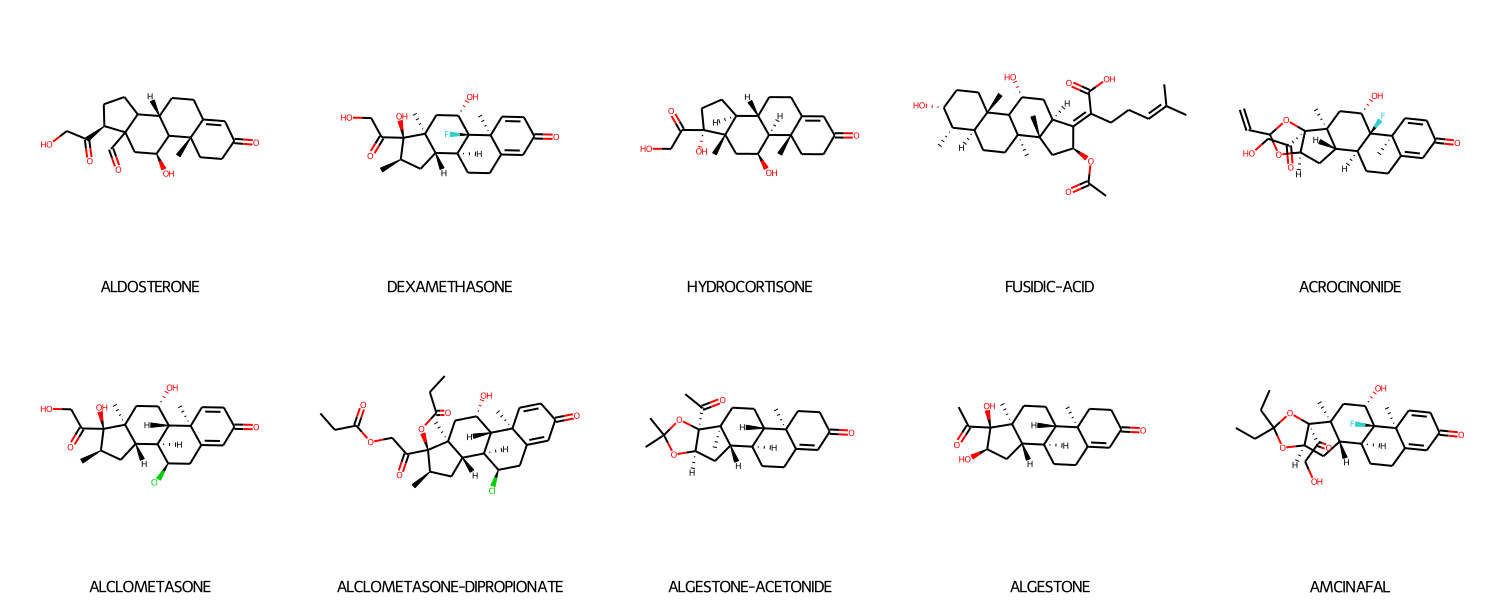

In [60]:
bbb_0 = bbb_df[bbb_df['Cluster_Index'] == 0]
mol_0 = [Chem.MolFromSmiles(s) for s in bbb_0['SMILES'].values[:10]]
Draw.MolsToGridImage(
    mol_0, 
    molsPerRow=5, 
    subImgSize=(300, 300), 
    legends=bbb_0['Drug'].values.tolist()[:10]
)

### Cluster 1

In [62]:
#Cluster 1 fragment counts for most important features
fragments_c1 = get_fragments(bbb_df[bbb_df['Cluster_Index'] == 1]['SMILES'], important_features[-50:])
fragments_c1 = fragments_c1.sort_values(by=['Count'], ascending=False)[1:]
fragments_c1.head(20)

,Fragment,Count
5,N(C)C,149
62,[C@H]1(NC)[C@@H](S)NC1=O,107
12,O(C)C,93
11,OC,93
63,C(C)(=O)N,86
0,C(N)(=O)C,70
10,c(c)(c)O,70
82,C(C)(=C)C,70
60,[C@H](N)(C)C,68
64,[C@@H](C)(N)C,65


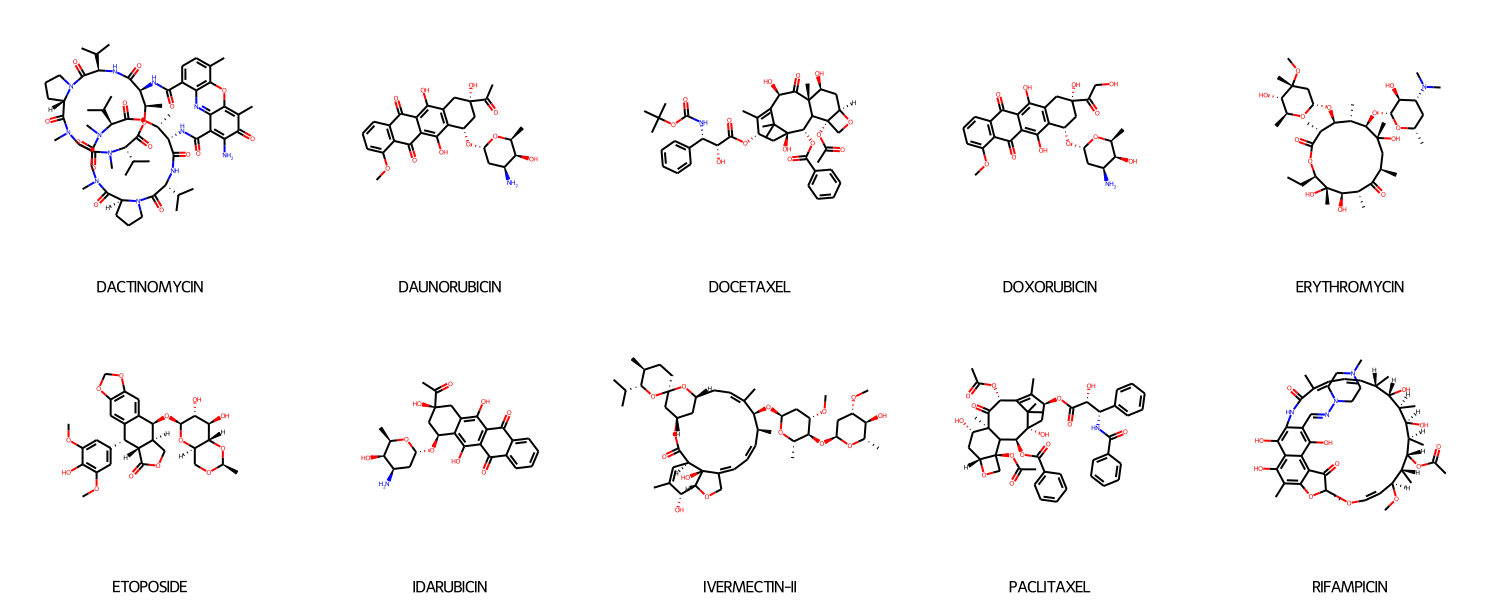

In [65]:
bbb_1 = bbb_df[bbb_df['Cluster_Index'] == 1]
mol_1 = [Chem.MolFromSmiles(s) for s in bbb_1['SMILES'].values[:10]]
Draw.MolsToGridImage(
    mol_1, 
    molsPerRow=5, 
    subImgSize=(300, 300), 
    legends=bbb_1['Drug'].values.tolist()[:10]
)

### Cluster 2

In [44]:
#Cluster 2 fragment counts for most important features
fragments_c2 = get_fragments(bbb_df[bbb_df['Cluster_Index'] == 2]['SMILES'], important_features[-50:])
fragments_c2 = fragments_c2.sort_values(by=['Count'], ascending=False)[1:]
fragments_c2.head(20)

,Fragment,Count
8,,284
2,N(C)(C)C,204
35,c(C)(c)c,86
37,c(c)(C)c,50
33,c(c(C)c)cc,40
16,N(C)(C)c,40
50,C(C)C,35
7,c(c)(c)C,35
127,c(N(C)c)(cc)c(c)S,33
12,c(cc)c(c)C,29


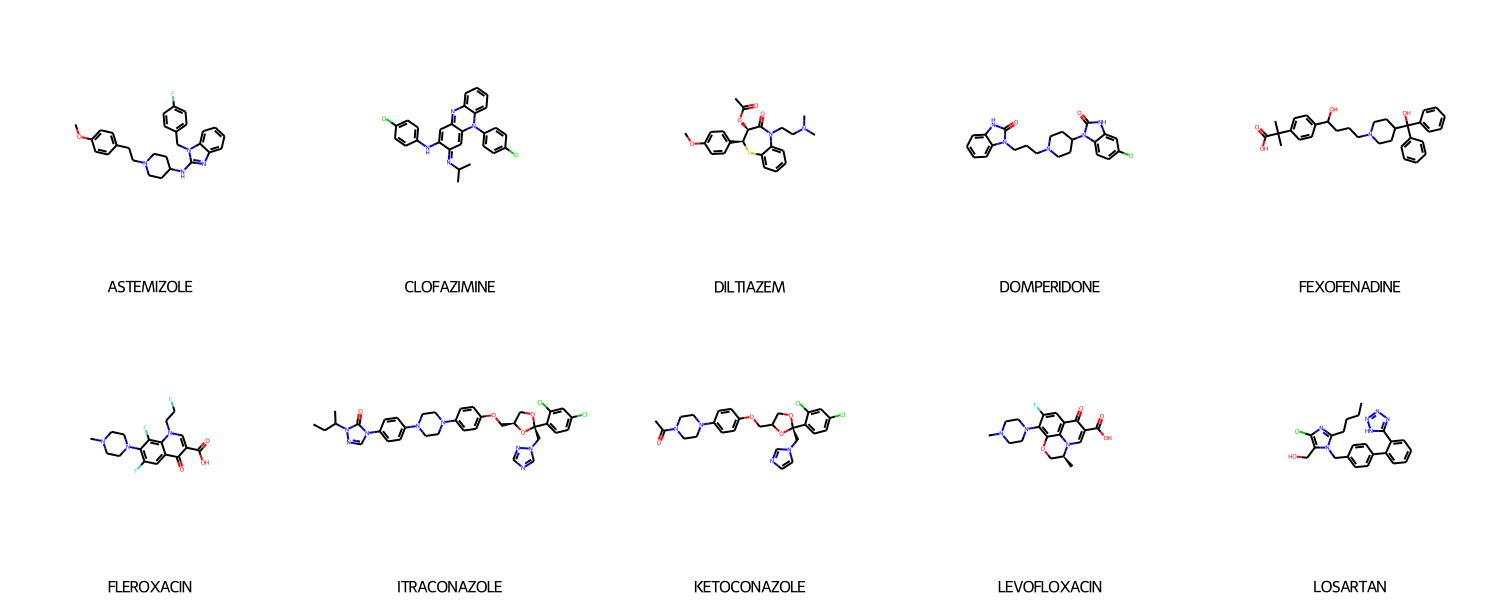

In [66]:
bbb_2 = bbb_df[bbb_df['Cluster_Index'] == 2]
mol_2 = [Chem.MolFromSmiles(s) for s in bbb_2['SMILES'].values[:10]]
Draw.MolsToGridImage(
    mol_2, 
    molsPerRow=5, 
    subImgSize=(300, 300), 
    legends=bbb_2['Drug'].values.tolist()[:10]
)

### Cluster 3

In [64]:
#Cluster 3 fragment counts for most important features
fragments_c3 = get_fragments(bbb_df[bbb_df['Cluster_Index'] == 3]['SMILES'], important_features[-50:])
fragments_c3 = fragments_c3.sort_values(by=['Count'], ascending=False)[1:]
fragments_c3.head(20)

,Fragment,Count
15,C(C)C,144
0,OC,130
21,c(C)(c)c,127
30,Oc,90
44,N(C)(C)C,84
18,N(C)C,79
46,c(c)(c)C,76
31,c(c)(c)O,72
23,O(C)C,57
85,NC,52


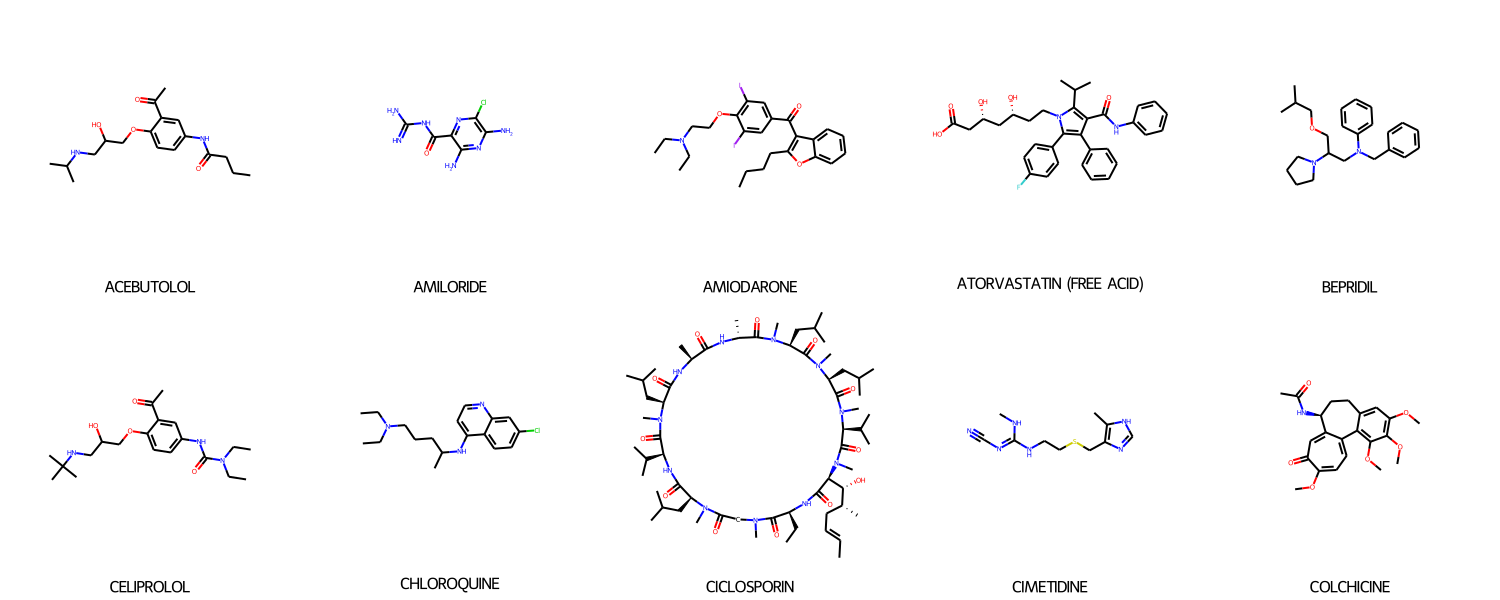

In [67]:
bbb_3 = bbb_df[bbb_df['Cluster_Index'] == 3]
mol_3 = [Chem.MolFromSmiles(s) for s in bbb_3['SMILES'].values[:10]]
Draw.MolsToGridImage(
    mol_3, 
    molsPerRow=5, 
    subImgSize=(300, 300), 
    legends=bbb_3['Drug'].values.tolist()[:10]
)